# Preparation & loading data



In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import scipy.signal as signal
from collections import defaultdict
import seaborn as sns

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

Column description according to the [UCI website.](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring
) 
> Attribute Information:
The 54 columns in the data files are organized as follows:
1. timestamp (s)
2. activityID (see below for the mapping to the activities)
3. heart rate (bpm)
4. -20. IMU hand
21. -37. IMU chest
38. -54. IMU ankle


>The IMU sensory data contains the following columns:
1.   temperature (°C)
2. -4. 3D-acceleration data (ms-2), scale: Â±16g, resolution: 13-bit
5. -7. 3D-acceleration data (ms-2), scale: Â±6g, resolution: 13-bit
8. -10. 3D-gyroscope data (rad/s)
11. -13. 3D-magnetometer data (Î¼T)
14. -17. orientation (invalid in this data collection)

>List of activityIDs and corresponding activities:
- 1: lying
- 2: sitting
- 3: standing
- 4: walking
- 5: running
- 6: cycling
- 7: Nordic walking
- 9: watching TV
- 10: computer work
- 11: car driving
- 12: ascending stairs
- 13: descending stairs
- 16: vacuum cleaning
- 17: ironing
- 18: folding laundry
- 19: house cleaning
- 20: playing soccer
- 24: rope jumping
- 0: other (transient activities)



In [2]:
# helper functions for loading the files, e.g. getting their path, names
def get_sys_path_to_data_dir(path_from_wd = None):
    return os.path.join(os.getcwd()+ path_from_wd)

def csv_file_names(path = None):
    data_dir = get_sys_path_to_data_dir(path)
    files = [f for f in os.listdir(data_dir) if f.endswith('.dat')]
    return files

def create_valid_master_dataset(df, class_check = False):
    master = pd.concat(df).reset_index()

    # Ensure targets are valid values (0-24) and we only have valid acceleration readings.
    is_activity = master['activityID'].isin(get_activities()) if class_check else None
    is_valid = master.x_vert_accel_16g_chest.notna()
    master_valid = master[is_activity& is_valid ] if class_check else master[is_valid]

    print(len(master)-len(master_valid), ' rows are invalid, which refers to %',round((1-(len(master_valid)/len(master)))*100,2) )
    return master_valid

def get_activities():
    activities = {
        0: "other (transient activities)", # activityLvl 1
        1: "lying", # activityLvl 0
        2: "sitting", # activityLvl 0
        3: "standing", # activityLvl 1
        4: "walking", # activityLvl 1
        5: "running", # activityLvl 2
        6: "cycling", # activityLvl 2
        7: "Nordic walking", # activityLvl 2
        9: "watching TV", # activityLvl 0
        10: "computer work", # activityLvl 0
        11: "car driving", # activityLvl 0
        12: "ascending stairs", # activityLvl 2
        13: "descending stairs", # activityLvl 1
        16: "vacuum cleaning",# activityLvl 1
        17: "ironing", # activityLvl 1
        18: "folding laundry", # activityLvl 1
        19: "house cleaning", # activityLvl 1
        20: "playing soccer",# activityLvl 2
        24: "rope jumping", # activityLvl 2
    }
    return activities


"""
This function represents the assignment of the activities from the top to three different activity levels (0-3) from 
sedentary to moderatly active to active.
"""
def get_activity_lvl_dict():
    activity_lvls = {
        0: 1,
        1: 0,
        2: 0,
        3: 1,
        4: 1,
        5: 2,
        6: 2,
        7: 2,
        9: 0,
        10: 0,
        11: 0,
        12: 2,
        13: 1,
        16: 1,
        17: 1,
        18: 1,
        19: 1,
        20: 2,
        24: 2,
    }
    return activity_lvls

#helper function that returns the array of the relevant columns from the dataset
def get_core_features():
    CORE_FEATURES =[
        "x_vert_accel_16g_chest",
        "y_lat_accel_16g_chest",
        "z_sagit_accel_16g_chest",
    ]
    return CORE_FEATURES

#The question marks indicate that the appropriate axes are not known a priori and need to 
# be identified empirically.
def get_col_labels():
    col_labels = [
        "timestamp(s)",
        "activityID",
        "heart_rate",
        "temperature_hand",
        "acceleration_?x_16g_hand",
        "acceleration_?y_16g_hand",
        "acceleration_?z_16g_hand",
        "acceleration_?x_8g_hand",
        "acceleration_?y_8g_hand",
        "acceleration_?z_8g_hand",
        "gyroscope_?x_hand",
        "gyroscope_?y_hand",
        "gyroscope_?z_hand",
        "magnetometer_?x_hand",
        "magnetometer_?y_hand",
        "magnetometer_?z_hand",
        "orientation_invalid_1_hand",
        "orientation_invalid_2_hand",
        "orientation_invalid_3_hand",
        "orientation_invalid_4_hand",
        "temperature_chest",
        "acceleration_?x_16g_chest",
        "acceleration_?y_16g_chest",
        "acceleration_?z_16g_chest",
        "acceleration_?x_8g_chest",
        "acceleration_?y_8g_chest",
        "acceleration_?z_8g_chest",
        "gyroscope_?x_chest",
        "gyroscope_?y_chest",
        "gyroscope_?z_chest",
        "magnetometer_?x_chest",
        "magnetometer_?y_chest",
        "magnetometer_?z_chest",
        "orientation_invalid_1_chest",
        "orientation_invalid_2_chest",
        "orientation_invalid_3_chest",
        "orientation_invalid_4_chest",
        "temperature_ankle",
        "acceleration_?x_16g_ankle",
        "acceleration_?y_16g_ankle",
        "acceleration_?z_16g_ankle",
        "acceleration_?x_8g_ankle",
        "acceleration_?y_8g_ankle",
        "acceleration_?z_8g_ankle",
        "gyroscope_?x_ankle",
        "gyroscope_?y_ankle",
        "gyroscope_?z_ankle",
        "magnetometer_?x_ankle",
        "magnetometer_?y_ankle",
        "magnetometer_?z_ankle",
        "orientation_invalid_1_ankle",
        "orientation_invalid_2_ankle",
        "orientation_invalid_3_ankle",
        "orientation_invalid_4_ankle",
        ]
    return col_labels

def load_raw_data():
    
    
    #get the system paths to the directories
    protocol_data_dir = get_sys_path_to_data_dir('\\PAMAP2_Dataset\\Protocol\\')
    optional_data_dir = get_sys_path_to_data_dir('\\PAMAP2_Dataset\\Optional\\')
    number_of_protocol_files = len(next(os.walk(protocol_data_dir))[2])
    
    column_labels = get_col_labels()
    
    # load the data to memory by saving each file as a dataframe in a dictionary (@dataset)
    # the file names should be named as ascending 
    dataset = {}
    for file_name in np.arange(number_of_protocol_files-1):
        df = (pd.read_csv(protocol_data_dir + str(file_name+1) + ".dat", names = column_labels,sep=" ", header=None)
            .rename(columns={"acceleration_?x_16g_chest": get_core_features()[0],
                                        "acceleration_?y_16g_chest": get_core_features()[1],
                                        "acceleration_?z_16g_chest": get_core_features()[2]})
              [["timestamp(s)",
                "activityID",
                "heart_rate",
                "temperature_chest",
                "x_vert_accel_16g_chest",
                "y_lat_accel_16g_chest",
                "z_sagit_accel_16g_chest"]])
        dataset[file_name] = df
    for file_name in np.arange(number_of_protocol_files,number_of_protocol_files+len(next(os.walk(optional_data_dir))[2])-1):
        df = (pd.read_csv(optional_data_dir + str(file_name) + ".dat", names = column_labels, sep=" ", header=None)
              .rename(columns={"acceleration_?x_16g_chest": get_core_features()[0],
                                        "acceleration_?y_16g_chest": get_core_features()[1],
                                        "acceleration_?z_16g_chest": get_core_features()[2]})
              [["timestamp(s)",
                "activityID",
                "heart_rate",
                "temperature_chest",
                "x_vert_accel_16g_chest",
                "y_lat_accel_16g_chest",
                "z_sagit_accel_16g_chest"]])
        dataset[file_name] = df
        
    return dataset

In [11]:
data_lib = load_raw_data()
len(data_lib)

14

In [15]:
# Creating master dataset
master_valid = create_valid_master_dataset(data_lib)
len(master_valid)

4310  rows are invalid, which refers to % 0.11


3846195

In [12]:
for x, group in master_valid.groupby('activityID'):
    print('Group ', x, ' ', len(group), ' instances, i.e. ',round(len(group)/100/60,2),'min' )
for x, group in master_valid.groupby('activity_intensity'):
    print('Group ', x, ' ', len(group), ' instances, i.e. ',round(len(group)/100/60,2),'min' )

NameError: name 'master_valid' is not defined

In [ ]:
master_valid

# Feature extraction & model training


In [ ]:
SAMPLE_SECONDS = 6
SAMPLE_OVERLAP = 0.5
SAMPLING_RATE = 100

def abs_rfft( series ):
    complex_fourier = np.fft.rfft( series )
    return np.absolute(complex_fourier)
    
def create_train_test_split(df):
    X = df.drop('target', axis=1)
    y = df['target']
    return train_test_split(X, y, test_size=0.2)

def standardize(df):
    """
    Make the mean of data 0 with standard dev of 1
    """
    return (df - df.mean()) / df.std() 


# Helper functions for windowing the data
def window(width, overlap, max_idx):
    """
    Generates tuples of indices that define a window
    of given width and overlap. 
    
    For example:
    window(width=10, overlap=0.5, max_length=30)
    (0, 10)
    (5, 15)
    (10, 20)
    (15, 25)
    Note: it trims the end; i.e. won't return (25, 30)
    """
    start = 0
    if overlap < 0.0 or overlap >= 1.:
        raise ValueError("overlap needs to be a number between 0 and 1")
    while True:
        end = start + width
        if end >= max_idx:
            return None
        yield start, end
        start += max(int((1-overlap)*width), 1)

        
def window_df(df, width, overlap):
    """
    Applies window to a dataframe
    """
    windows = window(width, overlap, len(df))
    for start, end in windows:
        yield df[start:end]



"""added the heart rate std to the core features"""
def create_features_from_dataset(df,  df_label=None):


    CORE_FEATURES = get_core_features()
  
    # 0-center the mean and normalize. this adds about 5 points
    df[CORE_FEATURES] = standardize(df[CORE_FEATURES])

    new_group = defaultdict(list)
    if df_label!=None:
        new_group['target'] = df_label
    samples = window_df(df, SAMPLE_SECONDS*SAMPLING_RATE, SAMPLE_OVERLAP)


    for idx,sample in enumerate(samples):

        # means of amplitudes
        means = sample[CORE_FEATURES].mean()
        new_group['x_accel_mean'].append(means["x_vert_accel_16g_chest"])
        new_group['y_accel_mean'].append(means['y_lat_accel_16g_chest'])
        new_group['z_accel_mean'].append(means['z_sagit_accel_16g_chest'])

        # standard deviation of amplitudes
        stds = sample[CORE_FEATURES].std()
        new_group['x_accel_std'].append(stds["x_vert_accel_16g_chest"])
        new_group['y_accel_std'].append(stds['y_lat_accel_16g_chest'])
        new_group['z_accel_std'].append(stds['z_sagit_accel_16g_chest'])
        #new_group['heart_std'].append(sample.heart_rate.std()) #added a parameter for heart rate

        # max-min
        new_group['x_max_min'].append(max(sample.x_vert_accel_16g_chest) - min(sample.x_vert_accel_16g_chest))
        new_group['y_max_min'].append(max(sample.y_lat_accel_16g_chest) - min(sample.y_lat_accel_16g_chest))
        new_group['z_max_min'].append(max(sample.z_sagit_accel_16g_chest) - min(sample.z_sagit_accel_16g_chest))
        #new_group['heart_max_min'].append(max(sample.heart_rate) - min(sample.heart_rate) if
          #                                max(sample.heart_rate) - min(sample.heart_rate)>=0 else 0)

        # xy, xz, yz correlations
        corrs = sample[CORE_FEATURES].corr()
        new_group['xy_corr'].append(corrs.loc['x_vert_accel_16g_chest', 'y_lat_accel_16g_chest'])
        new_group['xz_corr'].append(corrs.loc['x_vert_accel_16g_chest', 'z_sagit_accel_16g_chest'])
        new_group['yz_corr'].append(corrs.loc['y_lat_accel_16g_chest', 'z_sagit_accel_16g_chest'])

        # root-mean-square(x, y, z)
        rms = np.sqrt(np.mean(np.square(sample[CORE_FEATURES]), axis=1))
        new_group['rms_mean'].append(rms.mean())
        new_group['rms_std'].append(rms.std())


        # fourier transforms! 
        x_fft = abs_rfft(sample['x_vert_accel_16g_chest'])
        y_fft = abs_rfft(sample['y_lat_accel_16g_chest'])
        z_fft = abs_rfft(sample['z_sagit_accel_16g_chest'])

        new_group['x_fft_max'].append(x_fft.max())
        new_group['y_fft_max'].append(y_fft.max())
        new_group['z_fft_max'].append(z_fft.max())

        new_group['x_fft_min'].append(x_fft.min())
        new_group['y_fft_min'].append(y_fft.min())
        new_group['z_fft_min'].append(z_fft.min())

        new_group['x_fft_mean'].append(x_fft.mean())
        new_group['y_fft_mean'].append(y_fft.mean())
        new_group['z_fft_mean'].append(z_fft.mean())

        new_group['x_fft_std'].append(x_fft.std())
        new_group['y_fft_std'].append(y_fft.std())
        new_group['z_fft_std'].append(z_fft.std())

    return pd.DataFrame(new_group)

In [16]:
"""feature_matrix = []
#iterating over the master dataset & extracting the features for each activity seperatly
for target, df in master_valid.groupby('activityID'):
    feature_matrix.append(pd.DataFrame(create_features_from_dataset(df,target )))
feature_matrix = pd.concat(feature_matrix)


X_train, X_test, y_train, y_test = create_train_test_split(feature_matrix) """

# A training/ testing split can also be created based on the activity level
master_valid['activityLvl']= [get_activity_lvl_dict()[x] for x in master_valid.activityID ]
feature_matrix = []
for target, df in master_valid.groupby('activityLvl'):
    feature_matrix.append(pd.DataFrame(create_features_from_dataset(df,target )))
feature_matrix = pd.concat(feature_matrix)
X_train, X_test, y_train, y_test = create_train_test_split(feature_matrix)""" 

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-16-b4c5974ba48e>, line 16)

In [ ]:
rf= RandomForestClassifier(n_estimators=400, bootstrap=False, max_features='sqrt')

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
pickle.dump(rf, open('activityID_rf.sav', 'wb'))

# Visualization of most important model features

In [17]:
def plot_feature_importances(rf_model, feature_labels):
    # Features, sorted by importance:
    rf_feats = zip(rf_model.feature_importances_, feature_labels)
    rf_feats_sorted = sorted(rf_feats, key=lambda t: t[0])

    # Prepare to plot!
    x_vals = range(len(rf_feats_sorted))
    y_vals = [val for val,name in rf_feats_sorted]
    y_ticks = [name for val,name in rf_feats_sorted]
    fig = plt.figure(figsize=(6,8))
    plt.title("Relative feature importances model b)")
    plt.tick_params(labelsize='large')
    plt.yticks(x_vals, y_ticks)
    plt.barh(y=x_vals,width=y_vals)
    fig.set_facecolor('.9')
    
    return(rf_feats_sorted)
    

def visualize_combinations_of_most_important_features(df, feature_combinations, Title=None):
    colors = ['r','b','g']

    fig, axes = plt.subplots(2, 3, figsize=(18,8))
    axes = axes.flatten()

    for i,current_feature_comb in enumerate(feature_combinations):
        for color, activityLvl in df.groupby('activityLvl'):
            ax = axes[i]
            ax.set_ylabel(feature_combinations[i][1])
            ax.set_xlabel(feature_combinations[i][0])
            ax.set_title(f'{feature_combinations[i][0]} against {feature_combinations[i][1]}', fontweight='bold')
            ax.scatter(x=feature_combinations[i][0], y=feature_combinations[i][1], color = colors[color],s=5,
                      data=activityLvl)
    fig.set_facecolor('.9')
    fig.suptitle(Title,y=1.02, size=20)
    plt.tight_layout()
    
def visualize_combinations_of_most_important_features_hist(df,features, Title=None):
    colors = ['r','b','g']
    activity_lvl = ['inactive', 'moderatly active', 'active']

    fig, axes = plt.subplots(1,4, figsize=(16,5))
    axes = axes.flatten()

    for i,feature in enumerate(features):
        for color, activityLvl in df.groupby('activityLvl'):  # comment out, if classifier is based on activity lvl

            ax = axes[i]
            ax.set_xlabel('Value for '+ str(feature))
            ax.set_ylabel('occurences')
            ax.set_title(f'{feature}', fontweight='bold')
            ax.hist(x=feature, bins = 20, color = colors[color],
                      data=activityLvl, alpha=0.5, label=activity_lvl[color], density= True)
            ax.legend()
    fig.set_facecolor('.9')
    fig.suptitle(Title,y=1.02, size=15)
    plt.tight_layout()

In [18]:
most_important_feats

NameError: name 'most_important_feats' is not defined

In [ ]:
viz_data

In [ ]:
most_important_feats = plot_feature_importances(rf_lvl, list(X_train.columns)) #most important: y_accel_mean, z_max_min, z_accel_std, y_fft_mean

viz_data = (pd.concat([X_train, y_train], axis=1)
            .assign(activityLvl = lambda df_: [get_activity_lvl_dict()[x] for x in df_.target]) # comment out, if classifier is based on activity lvl
            #.assign(activityLvl = lambda df_: [x for x in df_.target]) # comment out, if classifier is based on activity lvl
            [['target','activityLvl','y_accel_mean', 'z_max_min', 'z_accel_std', 'y_fft_mean']])

feature_combinations= [['y_accel_mean', 'z_max_min'],
 ['y_accel_mean','z_accel_std'],
 ['y_accel_mean','y_fft_mean'],
 ['z_max_min','z_accel_std'],
 ['z_max_min','y_fft_mean'],
 ['z_accel_std', 'y_fft_mean']] 
features = ['y_accel_mean', 'z_max_min','z_accel_std', 'y_fft_mean']

#visualize_combinations_of_most_important_features(viz_data, feature_combinations, 'PAMAP2 dataset')
visualize_combinations_of_most_important_features_hist(viz_data, features, 'PAMAP2 dataset')


In [ ]:
most_important_features = ['y_accel_mean', 'z_max_min', 'z_accel_std', 'y_fft_mean']
    
for feature in most_important_features:
    sns.catplot(x='activityLvl', y=feature,
                  height=10, aspect=2,
                  data=viz_data, kind='box')
    sns.set_style({'figure.facecolor': '.9'})
    

# Loading D1namo dataset


In [ ]:
SEDENTARY_THRESHOLD = 0.02
ACTIVE_THRESHOLD = 0.6

#helper functions

def load_data2():
    protocol_data_dir = get_sys_path_to_data_dir('\\d1namo\\')
    dataset = {}
    """There should only be acceleration data files in the directory"""
    for file_name in np.arange(1, 3):
        
        """ The files need to be named after ascending integers, i.e. 1,2,3.."""
        df = pd.read_csv(protocol_data_dir + str(file_name) + ".csv", header=0) 
        dataset[file_name] = df
        
    return dataset

def load_summary_activity(df):

    new_group = defaultdict(list)
    
    samples = window_df(df, SAMPLE_SECONDS*SAMPLING_RATE, SAMPLE_OVERLAP)

    for idx,sample in enumerate(samples):
        
        #activity levels as in summary log
        new_group['s_sed_time']  = len(sample[sample.activity<= SEDENTARY_THRESHOLD])/SAMPLING_RATE
        new_group['s_active_time'] = len(sample[sample.activity>= ACTIVE_THRESHOLD])/SAMPLING_RATE
                                            
    return pd.DataFrame(new_group)

    


def transform_data(data_dict):
    transformed_data={}
    index = 0
    for key, data in data_dict.items():
        """
        Transforming each data sheet by subtracting 2048 from the sensor readings, dividing by 83 
        to get the acceleration in g and then multiplying by the gravity constant to get the acceleration 
        in m/s^2, as in the dataset used for training & testing the model. To keep the timestamps, the process 
        comprises two steps
        """
        transformed_data[index]=(((data_dict[key].iloc[:,1:4]-2048)/83)*9,81)[0]
        transformed_data[index]= (transformed_data[index]
                                  .rename(columns={"Vertical": get_core_features()[0],
                                                   "Lateral": get_core_features()[1],
                                                   "Sagittal": get_core_features()[2]}))
        transformed_data[index]['Time']= data_dict[key].iloc[:,0]
        #transformed_data[index]['activityLvl']= [x for x in rf.predict(create_features_from_dataset(create_valid_master_dataset(transformed_data[index])))]
        index=+1
    return transformed_data

In [ ]:
d1namo_dataset = transform_data(load_data2())

# Infering activity levels D1namo 


In [42]:
rf = pickle.load(open('activityID_rf.sav', 'rb'))
rf_lvl = pickle.load(open('activityLvl_rf.sav', 'rb'))


matplotlib.rcParams.update({'font.size': 22})



d1namo_dataset_features  = {}
"""iterating over the each file from the d1namo dataset separatly in order to attruibute each person's activity levels individually.
 Therefore, the validation, feature extraction and activity level prediction  needs to take place separatly as well"""
for indx in d1namo_dataset:
    d1namo_dataset_features[indx]= pd.DataFrame(create_features_from_dataset(create_valid_master_dataset([d1namo_dataset[indx]])))
    d1namo_dataset_features[indx]['activityLvl']=[get_activity_lvl_dict()[x] for x in rf.predict(d1namo_dataset_features[indx])]
    d1namo_dataset_features[indx]['activityLvl2'] =[x for x in rf_lvl.predict(d1namo_dataset_features[indx].iloc[:,:26])]
   # d1namo_dataset_features[indx] = pd.concat([d1namo_dataset_features[indx],load_summary_activity(d1namo_dataset[indx])], axis= 1,ignore_index=True)
    #d1namo_dataset_features[indx]['activityLvl']=[x for x in rf.predict(d1namo_dataset_features[indx])]




NameError: name 'matplotlib' is not defined

In [96]:
d1namo_dataset_features[1]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.478917,2.018795,-1.108438,2.734026,1.563953,2.095514,19.502886,10.628155,11.327576,0.155412,...,0.100102,0.341535,36.995321,22.082488,21.505676,75.565780,76.465753,60.237430,0,1
1,0.230191,0.527073,-1.020968,1.606799,1.059433,1.571187,14.302116,6.610194,9.392211,0.366318,...,0.314183,0.223102,21.637779,12.335649,17.166619,33.713034,29.157864,49.252437,2,1
2,-0.363383,-0.154684,-0.073113,0.848804,0.820057,0.594896,13.977068,15.683009,6.090707,-0.563040,...,5.182523,0.153826,16.769424,16.770809,8.828871,17.521349,12.207605,11.821352,2,2
3,-0.413043,0.087149,-0.084877,1.033864,0.812901,0.604538,14.843863,15.683009,6.090707,-0.471729,...,1.603799,0.451358,19.599989,16.744833,9.295114,21.408729,11.109533,11.850173,1,1
4,-0.453494,0.313538,0.001645,1.065991,0.370135,0.487562,11.376683,3.888349,4.610722,-0.142699,...,0.305866,0.315467,17.055556,7.216416,7.150843,25.170077,12.136659,9.528375,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8655,-0.380900,0.199047,-0.024065,0.157448,0.080599,0.076729,0.866795,1.166505,0.455380,0.015331,...,0.044782,0.126286,3.858997,2.089884,1.589892,13.169504,6.848219,1.296099,1,1
8656,-0.332142,0.550943,0.078111,0.205081,0.460315,0.207322,1.300192,2.592233,0.967682,0.482875,...,0.072234,0.033857,4.264414,4.371459,2.436490,11.785112,21.689315,5.198610,1,0
8657,-0.339004,0.671050,0.003353,0.205673,0.376418,0.260486,1.300192,1.620146,1.195372,0.507578,...,0.073579,0.137302,4.212440,4.210031,2.412776,12.040419,24.605714,5.891016,1,0
8658,-0.350742,0.658521,-0.003383,0.187488,0.297468,0.241827,1.083494,1.166505,1.138450,0.375072,...,0.126961,0.059811,4.044010,3.952761,2.282187,12.319457,23.576591,5.451574,1,0


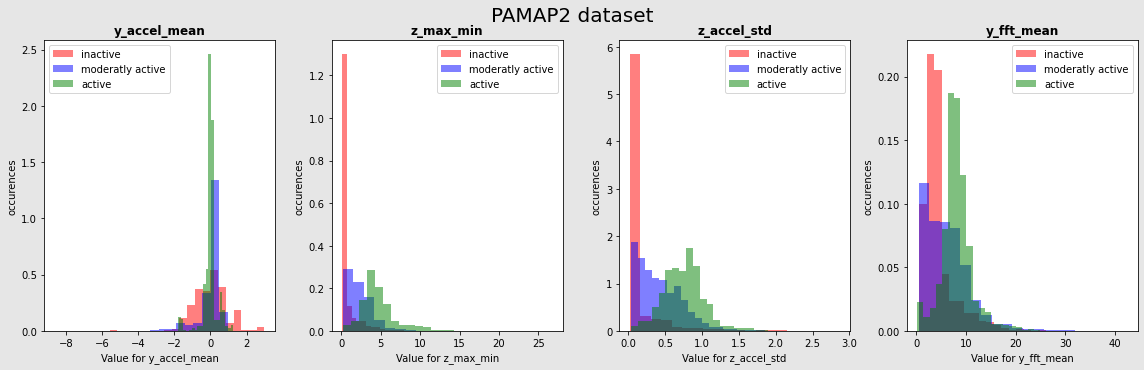

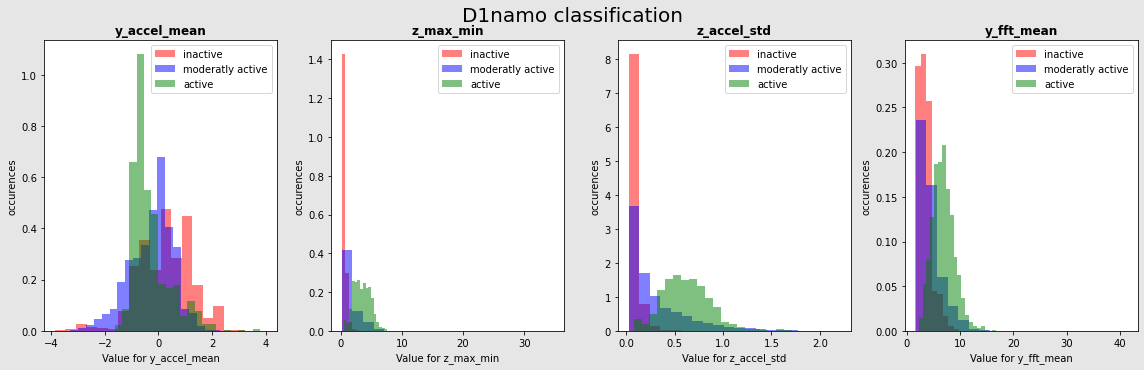

In [30]:
#visualize_combinations_of_most_important_features(d1namo_dataset_features[1],feature_combinations, 'D1namo classification')
#visualize_combinations_of_most_important_features(viz_data, feature_combinations, 'PAMAP2 dataset')
viz_data_d1 = pd.concat(d1namo_dataset_features , axis=0)
visualize_combinations_of_most_important_features_hist(viz_data, features, 'PAMAP2 dataset')
visualize_combinations_of_most_important_features_hist(viz_data_d1, features, 'D1namo classification')


In [31]:
viz_data_d1

x_accel_mean  y_accel_mean  z_accel_mean  x_accel_std  y_accel_std  \
0 0        -0.576541     -1.006744     -1.211271     1.495332     1.444160   
  1        -0.697613     -0.976854     -0.913937     1.176197     1.060631   
  2        -0.748149     -0.423158     -0.852319     0.180234     0.199535   
  3        -0.750582     -0.286557     -0.867492     0.170166     0.083191   
  4        -0.770040     -0.358822     -0.884233     0.543513     0.385605   
...              ...           ...           ...          ...          ...   
1 8655     -0.380900      0.199047     -0.024065     0.157448     0.080599   
  8656     -0.332142      0.550943      0.078111     0.205081     0.460315   
  8657     -0.339004      0.671050      0.003353     0.205673     0.376418   
  8658     -0.350742      0.658521     -0.003383     0.187488     0.297468   
  8659     -0.327447      0.610240      0.022137     0.180364     0.332523   

        z_accel_std  x_max_min  y_max_min  z_max_min   xy_corr  ...  \
0 0        0.700158  13.863820  11.810239   4.530527  0.109099  ...   
  1        0.533633  13.863820  10.716698   4.145860 -0.008985  ...   
  2        0.186765   0.972900   1.038864   1.581411 -0.048034  ...   
  3        0.142816   0.891825   0.656124   1.025780 -0.046642  ...   
  4        0.231962   6.567073   3.554007   1.581411 -0.058999  ...   
...             ...        ...        ...        ...       ...  ...   
1 8655     0.076729   0.866795   1.166505   0.455380  0.015331  ...   
  8656     0.207322   1.300192   2.592233   0.967682  0.482875  ...   
  8657     0.260486   1.300192   1.620146   1.195372  0.507578  ...   
  8658     0.241827   1.083494   1.166505   1.138450  0.375072  ...   
  8659     0.216958   1.083494   1.296116   0.967682  0.285776  ...   

        y_fft_min  z_fft_min  x_fft_mean  y_fft_mean  z_fft_mean  x_fft_std  \
0 0      1.030623   0.279241   26.757045   24.054256   12.692666  31.884366   
  1      1.676844   0.176908   20.478435   18.927192   10.289279  31.444221   
  2      0.052568   0.130290    4.771811    2.983009    4.729222  25.808276   
  3      0.038320   0.085482    4.643516    2.028130    4.046745  25.875231   
  4      0.222024   0.047789   11.789043    6.025858    5.362429  27.323423   
...           ...        ...         ...         ...         ...        ...   
1 8655   0.044782   0.126286    3.858997    2.089884    1.589892  13.169504   
  8656   0.072234   0.033857    4.264414    4.371459    2.436490  11.785112   
  8657   0.073579   0.137302    4.212440    4.210031    2.412776  12.040419   
  8658   0.126961   0.059811    4.044010    3.952761    2.282187  12.319457   
  8659   0.079391   0.050147    4.031412    3.825200    2.268296  11.464185   

        y_fft_std  z_fft_std  activityLvl  activityLvl2  
0 0     43.345107  43.432113            1             1  
  1     38.142053  32.606147            1             1  
  2     15.133860  29.449987            1             1  
  3      9.911051  29.930799            1             1  
  4     14.369080  30.634972            1             1  
...           ...        ...          ...           ...  
1 8655   6.848219   1.296099            1             1  
  8656  21.689315   5.198610            1             0  
  8657  24.605714   5.891016            1             0  
  8658  23.576591   5.451574            1             0  
  8659  22.288281   4.852070            1             0  

[23334 rows x 28 columns]

In [33]:
#visualize_combinations_of_most_important_features(d1namo_dataset_features[1],feature_combinations, 'D1namo classification')
#visualize_combinations_of_most_important_features(viz_data, feature_combinations, 'PAMAP2 dataset')
viz_data_d1 = pd.concat(d1namo_dataset_features , axis=0)
visualize_combinations_of_most_important_features_hist(viz_data, features, 'PAMAP2 dataset')
visualize_combinations_of_most_important_features_hist(viz_data_d1, features, 'D1namo classification model a)')
viz_data_d2['activityLvL'] =viz_data_d1[]
visualize_combinations_of_most_important_features_hist(viz_data_d1['activityLvL'] =viz_data_d1.activityLvl2, features, 'D1namo classification model b)')


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-33-8b80036ae087>, line 6)

<ipython-input-43-4904219d05ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_data_d1b['activityLvl'] = viz_data_d1.activityLvl2


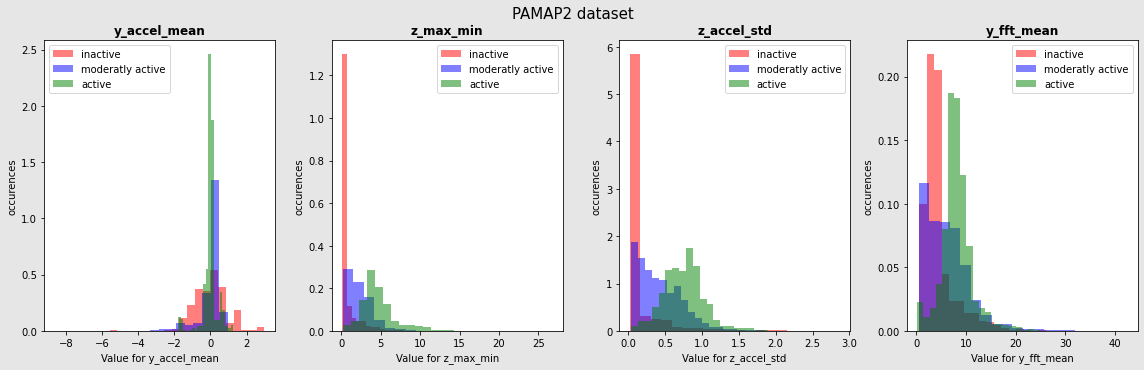

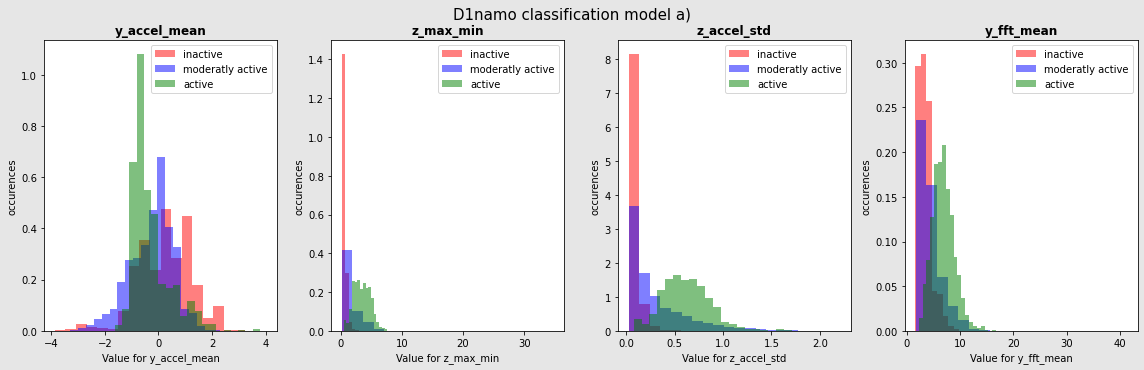

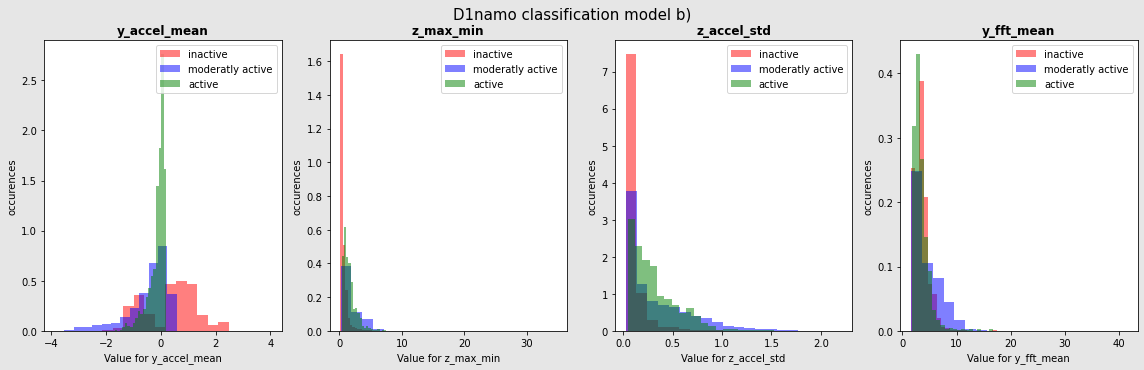

In [43]:
#visualize_combinations_of_most_important_features(d1namo_dataset_features[1],feature_combinations, 'D1namo classification')
#visualize_combinations_of_most_important_features(viz_data, feature_combinations, 'PAMAP2 dataset')
viz_data_d1 = pd.concat(d1namo_dataset_features , axis=0)
visualize_combinations_of_most_important_features_hist(viz_data, features, 'PAMAP2 dataset')
visualize_combinations_of_most_important_features_hist(viz_data_d1, features, 'D1namo classification model a)')
viz_data_d1b = viz_data_d1[['y_accel_mean', 'z_max_min', 'z_accel_std', 'y_fft_mean']]
viz_data_d1b['activityLvl'] = viz_data_d1.activityLvl2
visualize_combinations_of_most_important_features_hist(viz_data_d1b, features, 'D1namo classification model b)')


In [44]:
def check_for_consecutive_activity_lvl(df):
    SAMPLE_MINUTES = 5
    SAMPLE_OVERLAP = 0.5
    SAMPLING_RATE = 20 #3s feature window length = 20 windows per minute
    THRESHOLD = 0.9
    SECOND_THRESHOLD = 0.8
    THIRD_THRESHOLD =0.5
    upsample_rate = (SAMPLE_MINUTES/SAMPLE_OVERLAP)*SAMPLE_MINUTES


    samples = window_df(df, SAMPLE_MINUTES*SAMPLING_RATE, SAMPLE_OVERLAP)
    
    consecutive_activity_lvl = defaultdict(list)
    

    for idx, sample in enumerate(samples):
        ranked_act = sample.groupby('activityLvl').size().sort_values(ascending=False)
          #look for the second activity level?               
        if (ranked_act.iloc[0]/(SAMPLE_MINUTES*SAMPLING_RATE)) >=THRESHOLD:
            consecutive_activity_lvl['predominant_act_level'].append(ranked_act.index[0].astype(int))
        else:
            if (ranked_act.iloc[:2].sum()/(SAMPLE_MINUTES*SAMPLING_RATE)) >=SECOND_THRESHOLD:

                if (ranked_act.index[0] + ranked_act.index[1] != 2) and (ranked_act.iloc[0]/(SAMPLE_MINUTES*SAMPLING_RATE)) >=THIRD_THRESHOLD: 
                # can only be 2 if most & second_most are 2 and 0
                    consecutive_activity_lvl['predominant_act_level'].append(ranked_act.index[0].astype(int))
            else:          
                consecutive_activity_lvl['predominant_act_level'].append( -1)
                print(ranked_act)
    
    consecutive_activity_lvl = pd.DataFrame(np.repeat(pd.DataFrame(consecutive_activity_lvl).predominant_act_level,upsample_rate)).reset_index()
    df = df.join(consecutive_activity_lvl).fillna(-2)
    return df



activityLvl
1    47
2    29
0    24
dtype: int64
activityLvl
1    40
2    37
0    23
dtype: int64
activityLvl
1    55
2    24
0    21
dtype: int64
activityLvl
1    50
0    28
2    22
dtype: int64
activityLvl
1    51
0    27
2    22
dtype: int64


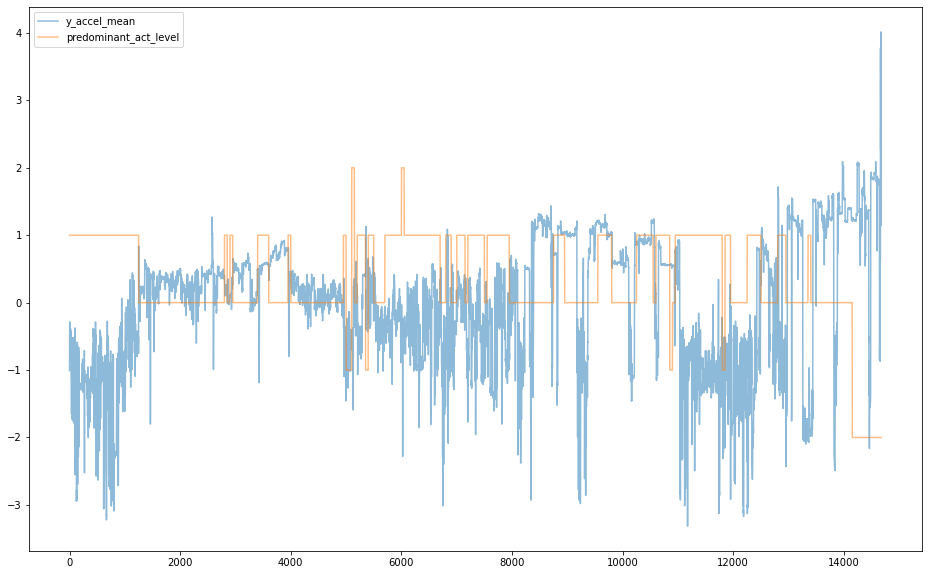

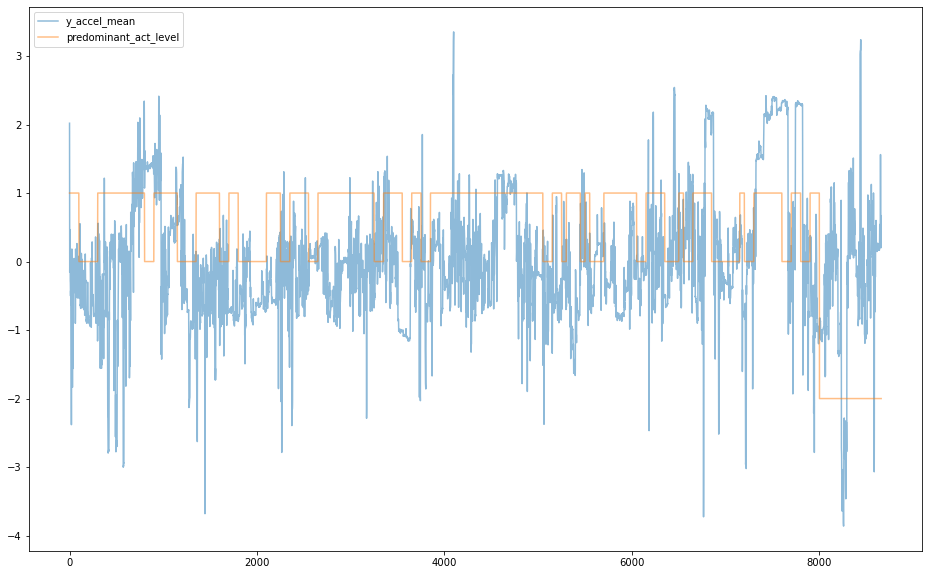

In [45]:


for indx in d1namo_dataset_features:
    check_for_consecutive_activity_lvl(d1namo_dataset_features[indx]).plot(y = ['y_accel_mean','predominant_act_level' ], alpha = 0.5,figsize=(16,10))
    #check_for_consecutive_activity_lvl(d1namo_dataset_features_unprecise[indx]).plot(y = ['y_accel_mean','predominant_act_level', ],figsize=(16,10))


In [46]:
def check_for_consecutive_activity_lvl_unprecise(df):
    SAMPLE_MINUTES = 5
    SAMPLE_OVERLAP = 0.5
    SAMPLING_RATE = 20 #3s feature window length = 20 windows per minute
    THRESHOLD = 0.1
    SECOND_THRESHOLD = 0.1
    THIRD_THRESHOLD =0.2
    upsample_rate = (SAMPLE_MINUTES/SAMPLE_OVERLAP)*SAMPLE_MINUTES


    samples = window_df(df, SAMPLE_MINUTES*SAMPLING_RATE, SAMPLE_OVERLAP)
    
    consecutive_activity_lvl = defaultdict(list)
    
    for indx, sample in enumerate(samples):
        most_indx = sample.groupby('activityLvl').size().sort_values(ascending=False).index[0]

        consecutive_activity_lvl['predominant_act_level'].append(most_indx)
    
    consecutive_activity_lvl = pd.DataFrame(np.repeat(pd.DataFrame(consecutive_activity_lvl).predominant_act_level,upsample_rate)).reset_index()
    df = df.join(consecutive_activity_lvl).fillna(-2)
    return df


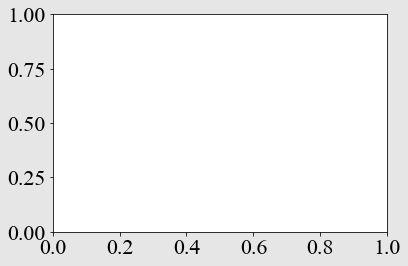

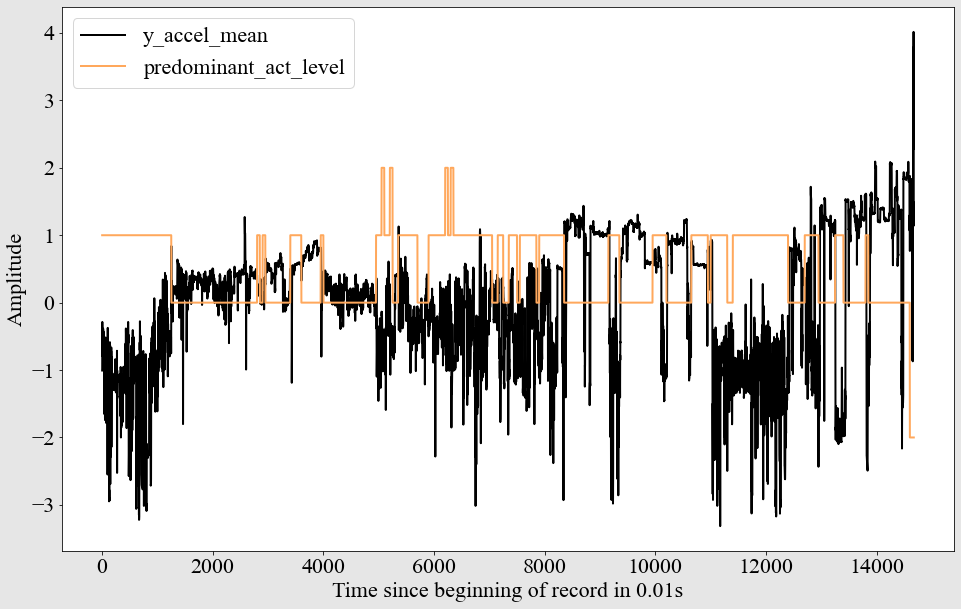

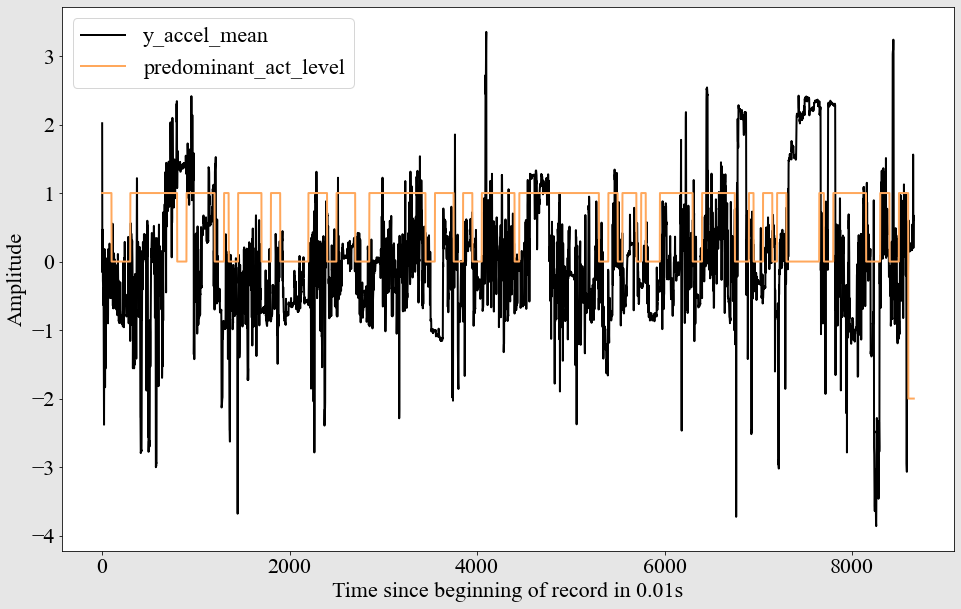

In [45]:


plt.rcParams.update({'font.size': 22})


fig, ax = plt.subplots()
plt.rcParams['figure.facecolor'] = '0.9'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
for indx in d1namo_dataset_features:
    #check_for_consecutive_activity_lvl(d1namo_dataset_features[indx]).plot(y = ['y_accel_mean','predominant_act_level', ],figsize=(16,10))
    x =  check_for_consecutive_activity_lvl_unprecise(d1namo_dataset_features[indx]).plot(y = ['y_accel_mean','predominant_act_level', ],figsize=(16,10),**{"color":('black','#FFA85C') }, linewidth=2)
    x.set_xlabel("Time since beginning of record in 0.01s")
    x.set_ylabel("Amplitude")
    x.set_




In [54]:
z['activity_class']= [0 if w < 0.02 else 1 for _,w in enumerate(z['activity_class']) ]

KeyError: 'activity_class'

# Retrieve Data

In [23]:
#get the file names:
def csv_file_names(path_from_wd= None, file_type ='csv'):
    path = os.path.join(os.getcwd() + path_from_wd)
    subject_folders = [name for name in os.listdir(path)]
    file_paths_dict = {}
    for index, subject_no in enumerate(subject_folders):
        subject_path = os.path.join(path + '\\' + subject_no)
        file_paths_dict[index+1] = {}
        file_paths_dict[index+1]['food_diary'] =  pd.read_csv(os.path.join(subject_path + '\\food.csv'))
        for index_2, folder in enumerate([subfolder for subfolder in os.listdir(os.path.join(subject_path + '\\sensor_data\\'))]):
            subject_path_sensor_log = [name for name in os.listdir(os.path.join(subject_path + '\\sensor_data\\' + folder + '\\'))]
            file_paths_dict[index+1][index_2+1]={}
            file_paths_dict[index+1][index_2+1]['accel'] = pd.read_csv(os.path.join(subject_path + '\\sensor_data\\' + folder + '\\'+ subject_path_sensor_log[0]))
            file_paths_dict[index+1][index_2+1]['summary'] = pd.read_csv(os.path.join(subject_path + '\\sensor_data\\' + folder + '\\'+subject_path_sensor_log[5]))                                                   
    return file_paths_dict



In [97]:
pd.read_csv('healthy_subset\\001\\sensor_data\\2014_10_01-12_50_01\\2014_10_01-12_50_01_Summary.csv')

,Time,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,BatteryLevel,BRAmplitude,...,SagittalPeak,DeviceTemp,StatusInfo,LinkQuality,RSSI,TxPower,CoreTemp,AuxADC1,AuxADC2,AuxADC3
0,01/10/2014 12:50:01.447,65,8.1,-3276.8,-68,0.41,1.22,4.176,96,5596.0,...,0.37,26.0,528,255,-128,-128,6553.5,409,405,469
1,01/10/2014 12:50:02.447,65,8.1,-3276.8,-48,1.01,2.43,4.176,96,5014.0,...,1.85,26.0,528,255,-128,-128,6553.5,413,419,480
2,01/10/2014 12:50:03.447,65,7.3,-3276.8,-26,0.61,1.62,4.176,96,4415.0,...,0.55,26.0,528,255,-128,-128,6553.5,414,419,480
3,01/10/2014 12:50:04.447,65,7.3,-3276.8,-16,0.46,0.93,4.176,96,3812.0,...,0.84,26.0,528,255,-128,-128,6553.5,415,419,480
4,01/10/2014 12:50:05.447,65,6.6,-3276.8,-12,0.25,0.74,4.176,96,3345.0,...,0.92,26.0,528,255,-128,-128,6553.5,414,420,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31395,01/10/2014 21:33:16.447,0,27.4,-3276.8,-80,0.09,0.14,3.869,44,273.0,...,0.18,31.4,535,255,-128,-128,37.4,414,418,479
31396,01/10/2014 21:33:17.447,0,27.5,-3276.8,-79,0.03,0.18,3.869,44,373.0,...,0.27,31.4,531,255,-128,-128,37.4,420,423,480
31397,01/10/2014 21:33:18.447,0,27.5,-3276.8,-78,0.06,0.09,3.869,44,394.0,...,0.21,31.4,531,255,-128,-128,37.4,414,416,479
31398,01/10/2014 21:33:19.447,0,27.5,-3276.8,-77,0.03,0.07,3.869,44,536.0,...,0.20,31.4,531,255,-128,-128,37.4,414,418,479


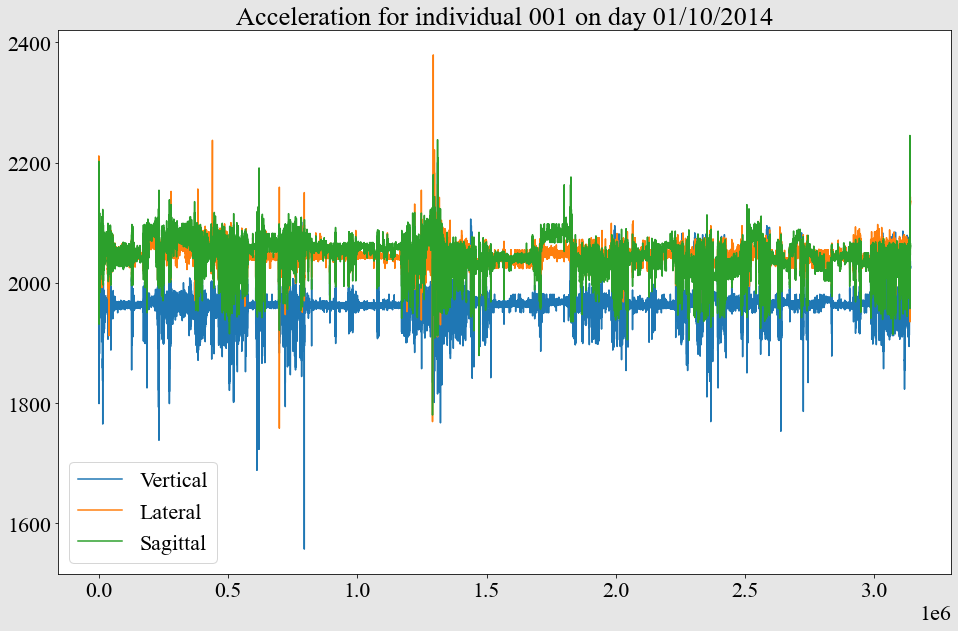

In [113]:
pd.read_csv('healthy_subset\\001\\sensor_data\\2014_10_01-12_50_01\\2014_10_01-12_50_01_Accel.csv').plot(figsize =(16,10), title= 'Acceleration for individual 001 on day 01/10/2014')

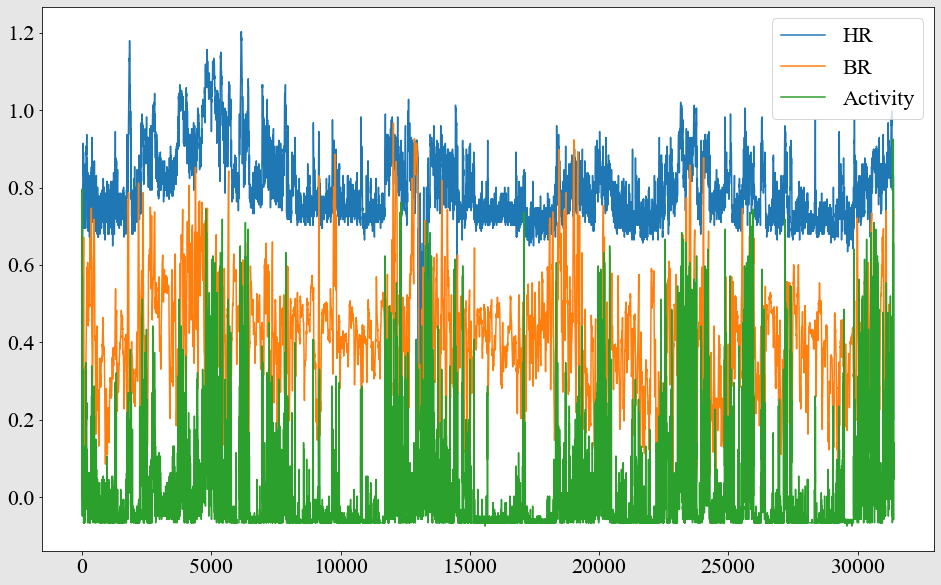

In [83]:
x = pd.read_csv('healthy_subset\\001\\sensor_data\\2014_10_01-12_50_01\\2014_10_01-12_50_01_Summary.csv').loc[:,['Time','HR','BR','Activity',]]
x['HR'] = normalize(x['HR'])+0.8
x['BR'] = normalize(x['BR'])+0.4
x['Activity'] = normalize(x['Activity'] )
x.plot(figsize =(16,10))

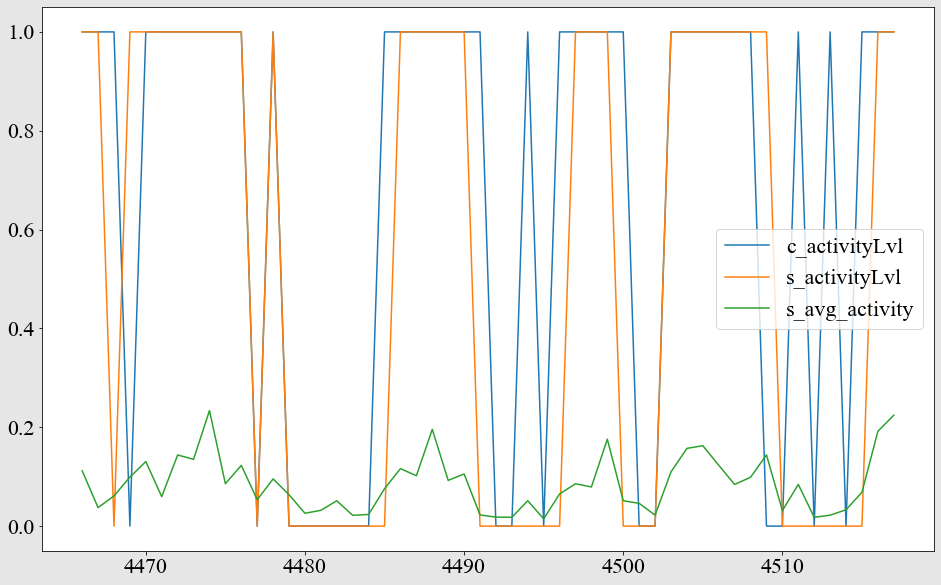

In [112]:
x = pd.read_csv('overall_summaryV1.1.csv')
x[(x.subject_id==1)& (x.Time <='02/10/2014' )].loc[:,['c_activityLvl','s_activityLvl','s_avg_activity']].plot(figsize=(16,10))